# Plots for ALPIDE analysis

## Preliminary operations

### Paths

In [1]:
import os

USER_PATH = os.getcwd()
DATA_PATH = USER_PATH + "/data/ALPIDE/"
SAVE_PATH = USER_PATH + "/plots/"

### Flags

In [2]:
UNZIP_DATA    = False
WAVE2NUMPY    = False
PLOT_WAVE     = False
PLOT_MAV_WAVE = False
REJECT_3SIGMA = False

### Load packages

In [3]:
import os
import ROOT
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bokeh.palettes as palette

Welcome to JupyROOT 6.22/02


In [4]:
from ROOT import TF1
from ROOT import TCanvas, TGraph, TGraphErrors

### Settings

In [5]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

In [6]:
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

<ipython-input-6-4c3d034b1475>:1: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\boldmath']


In [7]:
col = palette.brewer['RdYlGn'][10]

### Constants

In [8]:
MIN_MV   = 2400
MAX_MV   = 3500
BKG_RATE = 0.2951674822029528 #6.635    # ev/h

### Functions

In [9]:
def moving_average(x, M):
    return np.convolve(x, np.ones(M), 'valid') / M

## Beam profile plots

### Load data

#### Experimental data

In [184]:
df_exp = pd.read_csv(DATA_PATH + "ALPIDE_data_profile.csv")

#### Simulated data: load

In [185]:
df_sim = np.loadtxt(DATA_PATH + "ALPIDE_beam_profile.txt")

#### Simulated data: shift correction

In [186]:
shift       = np.average(df_exp["ALPIDE_step"], weights=df_exp["ALPIDE_r"])
df_sim[:,0] = df_sim[:,0] / 0.9 + shift

#### Simulated data: grouping + normalization

In [187]:
# group simulated data into the experimental data format (group by step)
sim_steps = []
sim_ev    = []
for step in df_exp["ALPIDE_step"]:
    ev = 0
    for i in range(df_sim.shape[0]-1):
        if (step >= df_sim[i,0]) and (step <= df_sim[i+1,0]):
            m  = (df_sim[i+1,1] - df_sim[i,1]) / (df_sim[i+1,0] - df_sim[i,0])
            ev = df_sim[i,1] + m * (step-df_sim[i,0])
            
    sim_steps.append(step)
    sim_ev.append(ev)

sim_steps = np.array(sim_steps)
sim_ev    = np.array(sim_ev)

# normalization
num = np.sum(df_exp["ALPIDE_r"]) # np.mean(df_exp["pico_r"][np.abs(df_exp["pico_step"])<=2])
den = np.sum(sim_ev)           # np.mean(sim_ev[np.abs(sim_steps)<=2])

sim_norm = num / den

#### Simulated data: put in dataframe

In [188]:
d_sim = {
    "ALPIDE_step"     : sim_steps,
    # "pico_rad"      : pico_rad,
    # "pico_deg"      : pico_deg,
    # "pico_seg"      : pico_seg,
    "ALPIDE_ev"       : sim_ev,
    # "pico_t"        : pico_t,
    "ALPIDE_r"        : sim_ev * sim_norm,
    # "pico_step_err" : pico_step_err,
    # "pico_rad_err"  : pico_rad_err,
    # "pico_deg_err"  : pico_deg_err,
    "ALPIDE_ev_err"   : np.sqrt(sim_ev),
    "ALPIDE_r_err"    : np.sqrt(sim_ev) * sim_norm
}

df_sim = pd.DataFrame(data=d_sim)
df_sim = df_sim.sort_values(by=['ALPIDE_step'])

### Compute residues

In [189]:
res_num =                   df_sim["ALPIDE_r"]      -           df_exp["ALPIDE_r"]
res_den = np.sqrt(np.square(df_sim["ALPIDE_r_err"]) + np.square(df_exp["ALPIDE_r_err"]))
res     = res_num  / res_den

### Plot and save

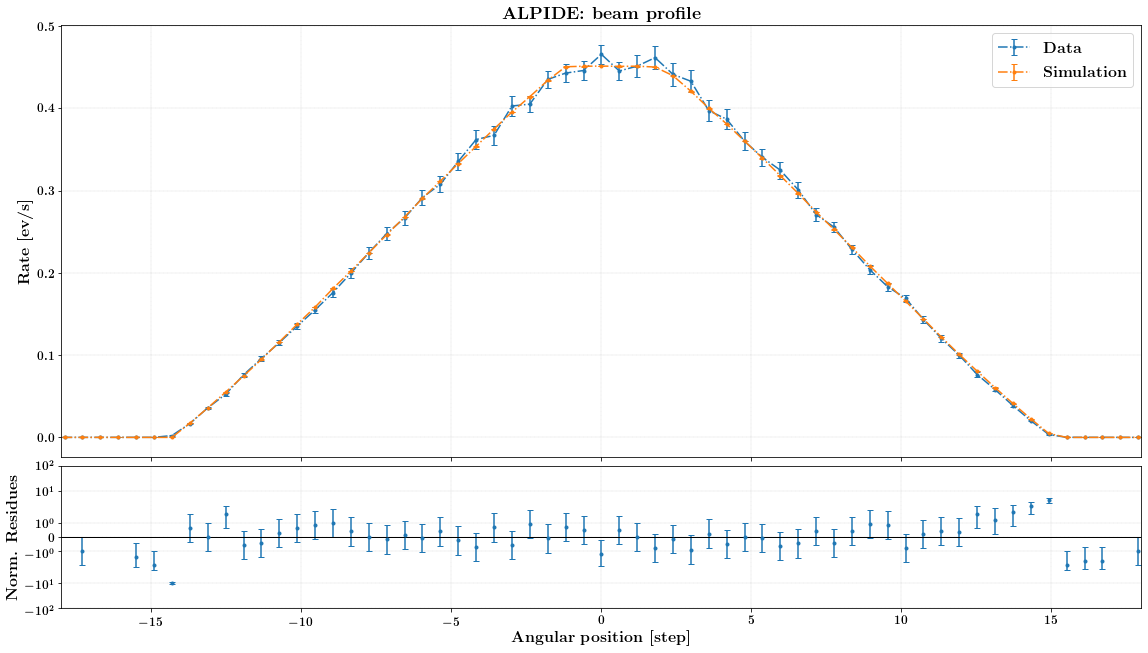

In [190]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(15,6))



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))

########## ERRORPLOT OF EXPERIMENTAL DATA
plt.errorbar(
    x               = df_exp["ALPIDE_step"],
    y               = df_exp["ALPIDE_r"],
    yerr            = df_exp["ALPIDE_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Data}",
    alpha           = 1
)

########## ERRORPLOT OF SIMULATED DATA
plt.errorbar(
    x               = df_sim["ALPIDE_step"],
    y               = df_sim["ALPIDE_r"],
    yerr            = df_sim["ALPIDE_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Simulation}",
    alpha           = 1
)

########## TOP PANEL SETTINGS
plt.ylabel(r"\bf{Rate [ev/s]}")
plt.title(r"\bf{ALPIDE: beam profile}")
plt.xlim(-18,18)
#plt.xticks(df_exp["ALPIDE_step"][df_exp["ALPIDE_step"] % 3 == 0])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,       # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
)
plt.legend()
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### BOTTOM PANEL
#######################################################################
fig.add_axes((0.,0.,1.0,0.33))

########## ERRORPLOT OF RESIDUES
plt.errorbar(
    x               = df_sim["ALPIDE_step"],
    y               = res,
    yerr            = np.ones(df_sim.shape[0]),
    fmt             ='o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Residues}",
    alpha           = 1
)

########## ZERO HLINE FOR RESIDUES
plt.axhline(y=0, color="black", linewidth=1)

########## BOTTOM PANEL SETTINGS
plt.xlim(-18,18)
plt.ylim(-100,100)
plt.yscale("symlog")
plt.ylabel(r"\bf{Norm. Residues}")
plt.xlabel(r"\bf{Angular position [step]}")
#plt.xticks(df_exp["ALPIDE_step"][df_exp["ALPIDE_step"] % 3 == 0])
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "ALPIDE/beam_profile.pdf", bbox_inches='tight')
#######################################################################


plt.show()
#######################################################################

# Compute $\chi^2$

In [191]:
print("$\chi^2$ = %f" % np.sum(res**2))
print("d.o.f = %f" % len(res))

$\chi^2$ = 185.646039
d.o.f = 301.000000


***

<br>
<br>
<br>
<br>
<br>

***

## Scattering profile plots

## Gold

### Load data

#### Experimental data

In [10]:
df_exp = pd.read_csv(DATA_PATH + "ALPIDE_data_gold.csv")

#### Simulated data: load

In [11]:
df_sim = np.loadtxt(DATA_PATH + "ALPIDE_sim2(1).txt")

#### Simulated data: shift correction

In [12]:
shift       = np.average(df_exp["ALPIDE_step"], weights=df_exp["ALPIDE_r"])
df_sim[:,0] = df_sim[:,0] / 0.9 + shift

#### Simulated data: grouping + normalization

In [13]:
# group simulated data into the experimental data format (group by step)
sim_steps = []
sim_ev    = []
for step in df_exp["ALPIDE_step"]:
    ev = 0
    for i in range(df_sim.shape[0]-1):
        if (step >= df_sim[i,0]) and (step <= df_sim[i+1,0]):
            m  = (df_sim[i+1,1] - df_sim[i,1]) / (df_sim[i+1,0] - df_sim[i,0])
            ev = df_sim[i,1] + m * (step-df_sim[i,0])
            
    sim_steps.append(step)
    sim_ev.append(ev)

sim_steps = np.array(sim_steps)
sim_ev    = np.array(sim_ev)

# normalization
num = np.sum(df_exp["ALPIDE_r"]) # np.mean(df_exp["pico_r"][np.abs(df_exp["pico_step"])<=2])
den = np.sum(sim_ev)           # np.mean(sim_ev[np.abs(sim_steps)<=2])

sim_norm = num / den

#### Simulated data: put in dataframe

In [14]:
d_sim = {
    "ALPIDE_step"     : sim_steps,
    # "pico_rad"      : pico_rad,
    # "pico_deg"      : pico_deg,
    # "pico_seg"      : pico_seg,
    "ALPIDE_ev"       : sim_ev,
    # "pico_t"        : pico_t,
    "ALPIDE_r"        : sim_ev * sim_norm,
    # "pico_step_err" : pico_step_err,
    # "pico_rad_err"  : pico_rad_err,
    # "pico_deg_err"  : pico_deg_err,
    "ALPIDE_ev_err"   : np.sqrt(sim_ev),
    "ALPIDE_r_err"    : np.sqrt(sim_ev) * sim_norm
}

df_sim = pd.DataFrame(data=d_sim)
df_sim = df_sim.sort_values(by=['ALPIDE_step'])

### Compute residues

In [15]:
res_num =                   df_sim["ALPIDE_r"]      -           df_exp["ALPIDE_r"]
res_den = np.sqrt(np.square(df_sim["ALPIDE_r_err"]) + np.square(df_exp["ALPIDE_r_err"]))
res     = res_num  / res_den

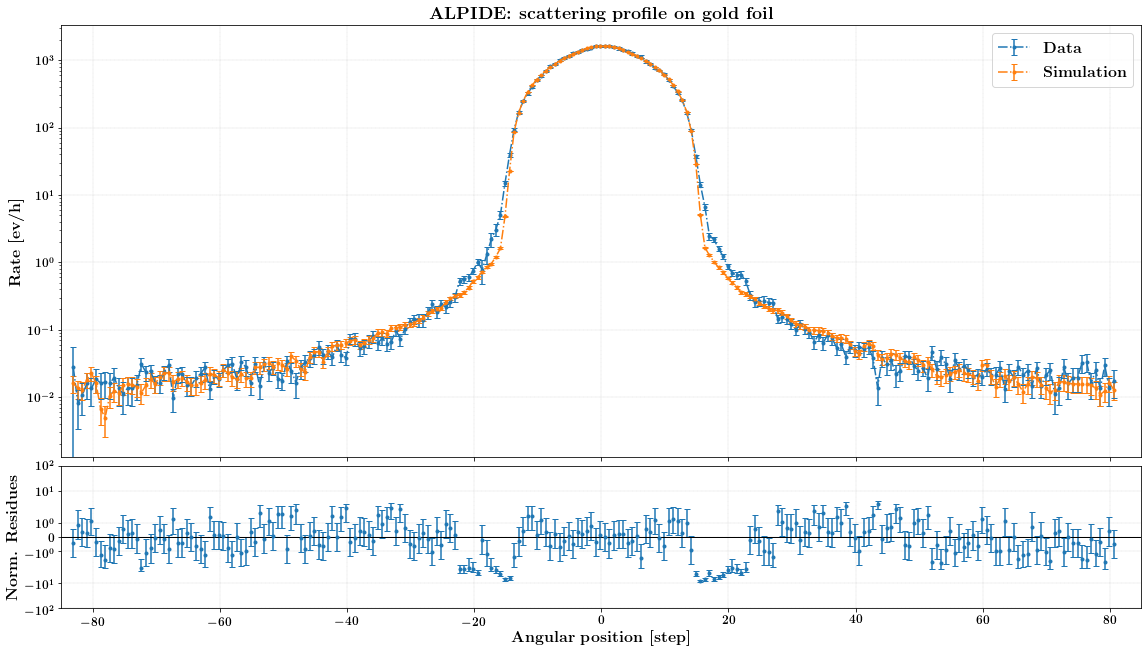

In [16]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(15,6))



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))

########## ERRORPLOT OF EXPERIMENTAL DATA
plt.errorbar(
    x               = df_exp["ALPIDE_step"],
    y               = df_exp["ALPIDE_r"],
    yerr            = df_exp["ALPIDE_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Data}",
    alpha           = 1
)

########## ERRORPLOT OF SIMULATED DATA
plt.errorbar(
    x               = df_sim["ALPIDE_step"],
    y               = df_sim["ALPIDE_r"],
    yerr            = df_sim["ALPIDE_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Simulation}",
    alpha           = 1
)

########## TOP PANEL SETTINGS
plt.yscale("log")
plt.ylabel(r"\bf{Rate [ev/h]}")
plt.title(r"\bf{ALPIDE: scattering profile on gold foil}")
plt.xlim(-85,85)
#plt.xticks(df_exp["ALPIDE_step"][df_exp["ALPIDE_step"] % 10 == 0])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,       # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
)
plt.legend()
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### BOTTOM PANEL
#######################################################################
fig.add_axes((0.,0.,1.0,0.33))

########## ERRORPLOT OF RESIDUES
plt.errorbar(
    x               = df_sim["ALPIDE_step"],
    y               = res,
    yerr            = np.ones(df_sim.shape[0]),
    fmt             ='o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Residues}",
    alpha           = 1
)

########## ZERO HLINE FOR RESIDUES
plt.axhline(y=0, color="black", linewidth=1)

########## BOTTOM PANEL SETTINGS
plt.xlim(-85,85)
plt.ylim(-100,100)
plt.yscale("symlog")
plt.ylabel(r"\bf{Norm. Residues}")
plt.xlabel(r"\bf{Angular position [step]}")
#plt.xticks(df_exp["ALPIDE_step"][df_exp["ALPIDE_step"] % 10 == 0])
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "ALPIDE/gold_scattering_profile.pdf", bbox_inches='tight')
#######################################################################


plt.show()
#######################################################################

# Compute $\chi^2$

In [17]:
mask_l = np.logical_and(df_exp["ALPIDE_step"] < -30, np.abs(res) < 1000)
mask_r = np.logical_and(df_exp["ALPIDE_step"] >  30, np.abs(res) < 1000)

res_masked_l = res[mask_l]
res_masked_r = res[mask_r]


print("$\chi$   = %f"   % np.sum(np.abs(res_masked_l)))
print("$\chi^2$ = %f" % np.sum(np.square(res_masked_l)))
print("d.o.f    = %f" % len(res_masked_l))

print("$\chi$   = %f"   % np.sum(np.abs(res_masked_r)))
print("$\chi^2$ = %f" % np.sum(np.square(res_masked_r)))
print("d.o.f    = %f" % len(res_masked_r))

print("$\chi$   = %f"   % np.sum(np.abs(res)))
print("$\chi^2$ = %f" % np.sum(np.square(res)))
print("d.o.f    = %f" % len(res))

$\chi$   = 56.890721
$\chi^2$ = 72.202930
d.o.f    = 75.000000
$\chi$   = 61.850647
$\chi^2$ = 82.615384
d.o.f    = 71.000000
$\chi$   = 253.554904
$\chi^2$ = 687.034425
d.o.f    = 230.000000


Dn,m 0.059174157436803765
Crit bound:  0.05558339475307323
1194.0000032420733
-30.195222895949453


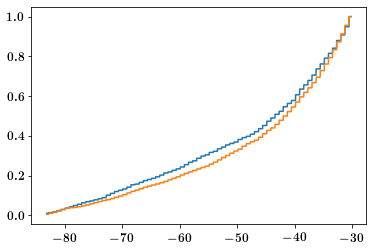

In [21]:
x_sim_left = df_sim[df_sim["ALPIDE_step"]<-30]["ALPIDE_step"]
y_sim_left = np.cumsum(df_sim[df_sim["ALPIDE_step"]<-30]["ALPIDE_r"])

x_dat_left = df_exp[df_exp["ALPIDE_step"]<-30]["ALPIDE_step"]
y_dat_left = np.cumsum(df_exp[df_exp["ALPIDE_step"]<-30]["ALPIDE_r"])


#k_n = tot_sim  * np.sum(y_sim_left)/np.sum(alpide_sim/norm)
#k_m = tot_data * np.sum(y_dat_left)/np.sum(counts_hratio_norm)
k_m = np.sum(df_exp[df_exp["ALPIDE_step"]<-30]["ALPIDE_ev"])



def left_data(xs):
    x = []
    for d in xs:
        x.append(y_dat_left[np.argmin(np.abs(x_dat_left-d))]/np.max(y_dat_left))
    return np.array(x)

def left_sim(xs):
    x = []
    for d in xs:
        x.append(y_sim_left[np.argmin(np.abs(x_sim_left-d))]/np.max(y_sim_left))
    return np.array(x)

x= np.linspace(max(np.min(x_sim_left), np.min(x_dat_left)),
                  min(np.max(x_sim_left), np.max(x_dat_left)), 2000)

#plt.plot(x_sim_left, y_sim_left/np.max(y_sim_left))
#plt.plot(x_dat_left, y_dat_left/np.max(y_dat_left))
plt.plot(x, left_data(x))
plt.plot(x, left_sim(x))

dist = np.abs(np.max(np.abs(left_data(x)-left_sim(x))))

alpha = 0.05
crit_value = np.sqrt(-np.log(alpha/2)*(1/k_m))#(1+k_m/k_n)/(2*k_m))

print("Dn,m", dist)
print("Crit bound: ", crit_value)
#print(k_n, k_m)
print(k_m)

print(max(np.max(x_sim_left), np.max(x_dat_left)))

In [ ]:
df_gold = pd.read_csv(DATA_PATH + "ALPIDE_data_gold.csv")
df_tin  = pd.read_csv(DATA_PATH + "ALPIDE_data_tin.csv")

In [ ]:
plt.errorbar(
    x               = df_gold["ALPIDE_step"],
    y               = df_gold["ALPIDE_r"],
    yerr            = df_gold["ALPIDE_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    color           = 'gold',
    label           = r"\bf{Gold}",
    alpha           = 1
)

plt.errorbar(
    x               = df_tin["ALPIDE_step"],
    y               = df_tin["ALPIDE_r"],
    yerr            = df_tin["ALPIDE_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    color           = 'silver',
    label           = r"\bf{Tin}",
    alpha           = 1
)

########## TOP PANEL SETTINGS
plt.yscale("log")
plt.ylabel(r"\bf{Rate [ev/s]}")
plt.title(r"\bf{ALPIDE: comparison}")
plt.xlim(-85,85)
plt.xticks(df_gold["ALPIDE_step"][df_gold["ALPIDE_step"] % 10 == 0])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,       # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
)
plt.legend()
plt.grid(linestyle='--', linewidth=0.25)


plt.show()

In [ ]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

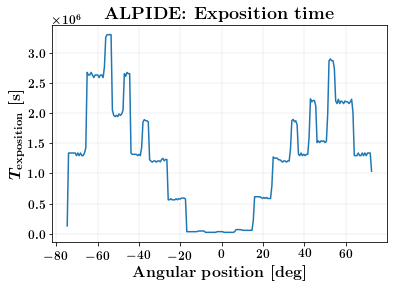

In [286]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(6,4))

plt.errorbar(
    x               = df_gold["ALPIDE_deg"],
    y               = df_gold["ALPIDE_t"],
    fmt             ='-',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Data}",
    alpha           = 1
)

plt.title(r"\bf{ALPIDE: Exposition time}")
plt.ylabel(r"\bf{$T_{\mathrm{exposition}}$ [s]}")
plt.xlabel(r"\bf{Angular position [deg]}")
#plt.xticks(df_exp["ALPIDE_step"][df_exp["ALPIDE_step"] % 10 == 0])
plt.grid(linestyle='--', linewidth=0.25)

#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "ALPIDE/gold_scattering_time.pdf", bbox_inches='tight')
#######################################################################


plt.show()
#######################################################################

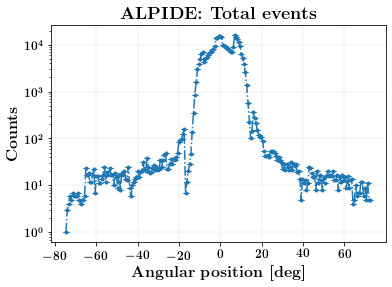

In [252]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(6,4))

plt.errorbar(
    x               = df_gold["ALPIDE_deg"],
    y               = df_gold["ALPIDE_ev"],
    yerr            = df_gold["ALPIDE_ev_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Data}",
    alpha           = 1
)

plt.title(r"\bf{ALPIDE: Total events}")
plt.yscale("log")
plt.ylabel(r"\bf{Counts}")
plt.xlabel(r"\bf{Angular position [deg]}")
#plt.xticks(df_exp["ALPIDE_step"][df_exp["ALPIDE_step"] % 10 == 0])
plt.grid(linestyle='--', linewidth=0.25)

#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "ALPIDE/gold_scattering_counts.pdf", bbox_inches='tight')
#######################################################################


plt.show()
#######################################################################

## Tin

In [253]:
df_exp = pd.read_csv(DATA_PATH + "ALPIDE_data_tin.csv")

In [261]:
df_sim = np.loadtxt(DATA_PATH + "ALPIDE_sim2(1).txt")

In [262]:
shift       = np.average(df_exp["ALPIDE_step"], weights=df_exp["ALPIDE_r"])
df_sim[:,0] = df_sim[:,0] / 0.9 + shift

In [263]:
# group simulated data into the experimental data format (group by step)
sim_steps = []
sim_ev    = []
for step in df_exp["ALPIDE_step"]:
    ev = 0
    for i in range(df_sim.shape[0]-1):
        if (step >= df_sim[i,0]) and (step <= df_sim[i+1,0]):
            m  = (df_sim[i+1,1] - df_sim[i,1]) / (df_sim[i+1,0] - df_sim[i,0])
            ev = df_sim[i,1] + m * (step-df_sim[i,0])
            
    sim_steps.append(step)
    sim_ev.append(ev)

sim_steps = np.array(sim_steps)
sim_ev    = np.array(sim_ev)

# normalization
num = np.sum(df_exp["ALPIDE_r"]) # np.mean(df_exp["pico_r"][np.abs(df_exp["pico_step"])<=2])
den = np.sum(sim_ev)           # np.mean(sim_ev[np.abs(sim_steps)<=2])

sim_norm = num / den

In [264]:
d_sim = {
    "ALPIDE_step"     : sim_steps,
    # "pico_rad"      : pico_rad,
    # "pico_deg"      : pico_deg,
    # "pico_seg"      : pico_seg,
    "ALPIDE_ev"       : sim_ev,
    # "pico_t"        : pico_t,
    "ALPIDE_r"        : sim_ev * sim_norm,
    # "pico_step_err" : pico_step_err,
    # "pico_rad_err"  : pico_rad_err,
    # "pico_deg_err"  : pico_deg_err,
    "ALPIDE_ev_err"   : np.sqrt(sim_ev),
    "ALPIDE_r_err"    : np.sqrt(sim_ev) * sim_norm
}

df_sim = pd.DataFrame(data=d_sim)
df_sim = df_sim.sort_values(by=['ALPIDE_step'])

In [265]:
res_num =                   df_sim["ALPIDE_r"]      -           df_exp["ALPIDE_r"]
res_den = np.sqrt(np.square(df_sim["ALPIDE_r_err"]) + np.square(df_exp["ALPIDE_r_err"]))
res     = res_num  / res_den

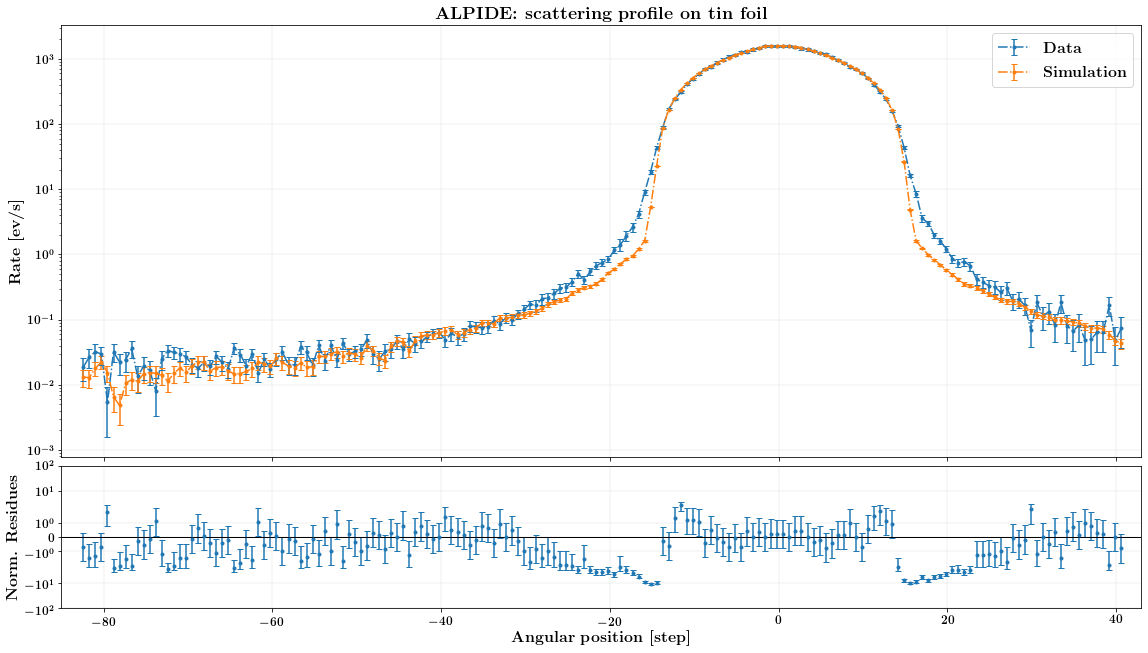

In [266]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(15,6))



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))

########## ERRORPLOT OF EXPERIMENTAL DATA
plt.errorbar(
    x               = df_exp["ALPIDE_step"],
    y               = df_exp["ALPIDE_r"],
    yerr            = df_exp["ALPIDE_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Data}",
    alpha           = 1
)

########## ERRORPLOT OF SIMULATED DATA
plt.errorbar(
    x               = df_sim["ALPIDE_step"],
    y               = df_sim["ALPIDE_r"],
    yerr            = df_sim["ALPIDE_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Simulation}",
    alpha           = 1
)

########## TOP PANEL SETTINGS
plt.yscale("log")
plt.ylabel(r"\bf{Rate [ev/s]}")
plt.title(r"\bf{ALPIDE: scattering profile on tin foil}")
plt.xlim(-85,43)
#plt.xticks(df_exp["ALPIDE_step"][df_exp["ALPIDE_step"] % 10 == 0])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,       # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
)
plt.legend()
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### BOTTOM PANEL
#######################################################################
fig.add_axes((0.,0.,1.0,0.33))

########## ERRORPLOT OF RESIDUES
plt.errorbar(
    x               = df_sim["ALPIDE_step"],
    y               = res,
    yerr            = np.ones(df_sim.shape[0]),
    fmt             ='o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Residues}",
    alpha           = 1
)

########## ZERO HLINE FOR RESIDUES
plt.axhline(y=0, color="black", linewidth=1)

########## BOTTOM PANEL SETTINGS
plt.xlim(-85,43)
plt.ylim(-100,100)
plt.yscale("symlog")
plt.ylabel(r"\bf{Norm. Residues}")
plt.xlabel(r"\bf{Angular position [step]}")
#plt.xticks(df_exp["ALPIDE_step"][df_exp["ALPIDE_step"] % 10 == 0])
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "ALPIDE/tin_scattering_profile.pdf", bbox_inches='tight')
#######################################################################


plt.show()
#######################################################################

# Compute $\chi^2$

In [267]:
print("$\chi^2$ = %f" % np.sum(res[df_exp["ALPIDE_step"]<-30]**2))
print("d.o.f = %f" % len(res[df_exp["ALPIDE_step"]<-30]))

print("$\chi^2$ = %f" % np.sum(res[df_exp["ALPIDE_step"]>30]**2))
print("d.o.f = %f" % len(res[df_exp["ALPIDE_step"]>30]))

$\chi^2$ = 87.222069
d.o.f = 74.000000
$\chi^2$ = 11.171587
d.o.f = 15.000000


Dn,m 0.07876018876848812
Crit bound:  0.05122176873419666
1406.0000028193494
-30.18502917677596


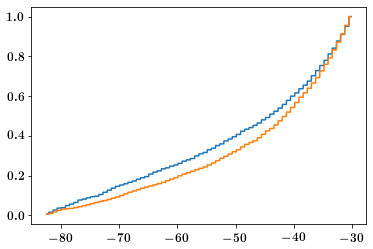

In [273]:
x_sim_left = df_sim[df_sim["ALPIDE_step"]<-30]["ALPIDE_step"]
y_sim_left = np.cumsum(df_sim[df_sim["ALPIDE_step"]<-30]["ALPIDE_r"])

x_dat_left = df_exp[df_exp["ALPIDE_step"]<-30]["ALPIDE_step"]
y_dat_left = np.cumsum(df_exp[df_exp["ALPIDE_step"]<-30]["ALPIDE_r"])


#k_n = tot_sim  * np.sum(y_sim_left)/np.sum(alpide_sim/norm)
#k_m = tot_data * np.sum(y_dat_left)/np.sum(counts_hratio_norm)
k_m = np.sum(df_exp[df_exp["ALPIDE_step"]<-30]["ALPIDE_ev"])



def left_data(xs):
    x = []
    for d in xs:
        x.append(y_dat_left[np.argmin(np.abs(x_dat_left-d))]/np.max(y_dat_left))
    return np.array(x)

def left_sim(xs):
    x = []
    for d in xs:
        x.append(y_sim_left[np.argmin(np.abs(x_sim_left-d))]/np.max(y_sim_left))
    return np.array(x)

x= np.linspace(max(np.min(x_sim_left), np.min(x_dat_left)),
                  min(np.max(x_sim_left), np.max(x_dat_left)), 2000)

#plt.plot(x_sim_left, y_sim_left/np.max(y_sim_left))
#plt.plot(x_dat_left, y_dat_left/np.max(y_dat_left))
plt.plot(x, left_data(x))
plt.plot(x, left_sim(x))

dist = np.abs(np.max(np.abs(left_data(x)-left_sim(x))))

alpha = 0.05
crit_value = np.sqrt(-np.log(alpha/2)*(1/k_m))#(1+k_m/k_n)/(2*k_m))

print("Dn,m", dist)
print("Crit bound: ", crit_value)
#print(k_n, k_m)
print(k_m)

print(max(np.max(x_sim_left), np.max(x_dat_left)))